## Bayes classifier for Binary Classification from scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import random
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
train1 = pd.read_csv('train1.csv', index_col=0)
train2 = pd.read_csv('train2.csv', index_col=0)
train3 = pd.read_csv('train3.csv', index_col=0)

test1 = pd.read_csv('test1.csv', index_col=0)
test2 = pd.read_csv('test2.csv', index_col=0)
test2

,x1,x2,y
0,3.472481,3.680828,1.0
1,6.270101,2.378943,1.0
2,6.116114,5.097277,1.0
3,5.232966,5.115128,1.0
4,3.655956,0.912040,1.0
...,...,...,...
395,-0.478637,1.164457,0.0
396,5.652354,2.375530,1.0
397,4.841827,3.260956,1.0
398,6.149805,3.134701,1.0


In [3]:
# Getting the data for each class
train1_c0 = train1[train1.y == 0.0]
train1_c1 = train1[train1.y == 1.0]
train2_c0 = train2[train2.y == 0.0]
train2_c1 = train2[train2.y == 1.0]
train2_c1.head()

,x1,x2,y
2,4.330579,4.413520,1.0
4,3.819236,4.541018,1.0
5,3.200349,2.999862,1.0
7,4.430816,3.592408,1.0
8,3.769091,2.995902,1.0


#### A function in order to calculate covariance matrices

In [4]:
def cov_matrix(data):
    n = len(data)
    # calculating means, variances, and covariances
    mu1 = data.x1.mean()
    mu2 = data.x2.mean()
    var_x1 = ((data.x1 - mu1)**2).sum()/(n-1)
    var_x2 = ((data.x2 - mu2)**2).sum()/(n-1)
    cov_x1x2 = ((data.x1 - mu1)*(data.x2 - mu2)).sum()/(n-1)
    
    #constructing the cov matrix
    covmat = np.array([round(var_x1,6), round(cov_x1x2,6), round(cov_x1x2,6), round(var_x2,6)]).reshape(-1,2)
    return(covmat)

In [5]:
def plot_cov_matrix(cov_mtrx):
    alpha = ['x1', 'x2']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cov_mtrx, interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)

#### Plotting a cov matrix

In [6]:
cov_matrix(train1_c0)

array([[ 0.65161 , -0.019441],
       [-0.019441,  0.365065]])

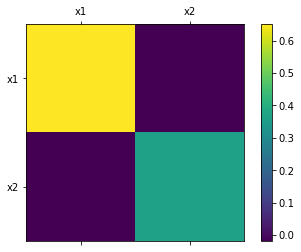

In [7]:
plot_cov_matrix(cov_matrix(train1_c0))

* A covariance value of -0.019441 (close to zero)indicates that the two variables (x1, x2) are almost not correlated.
* x1 has higher variance compared to x2.

#### Double checking the cov matrix with the cov function of pandas

In [8]:
train1_c0[['x1','x2']].cov()

,x1,x2
x1,0.651610,-0.019441
x2,-0.019441,0.365065


Results are the same.

### Plotting feature distributions in each dataset


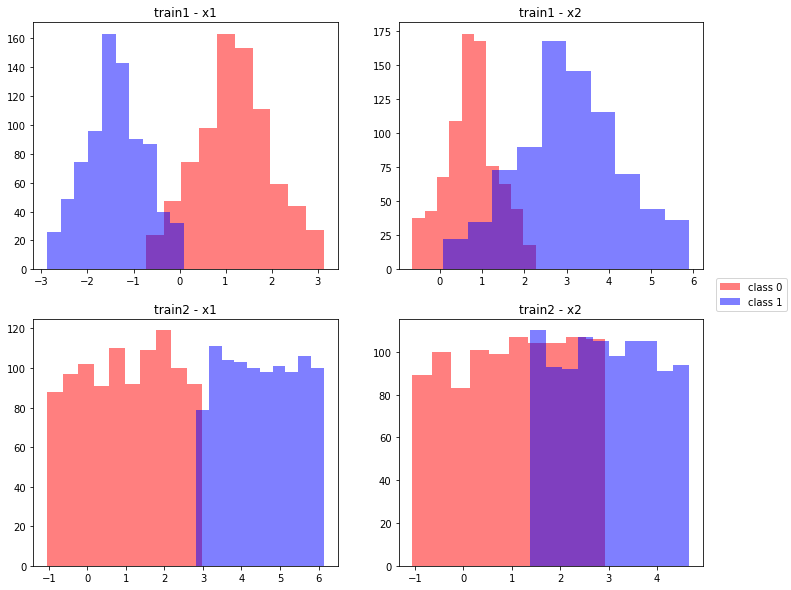

In [9]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(train1_c0.x1, color='red', alpha=0.5)
ax[0, 0].hist(train1_c1.x1, color='blue', alpha=0.5)
ax[0, 0].set_title('train1 - x1')

ax[0, 1].hist(train1_c0.x2, color='red', alpha=0.5)
ax[0, 1].hist(train1_c1.x2, color='blue', alpha=0.5)
ax[0, 1].set_title('train1 - x2')

ax[1, 0].hist(train2_c0.x1, color='red', alpha=0.5)
ax[1, 0].hist(train2_c1.x1, color='blue', alpha=0.5)
ax[1, 0].set_title('train2 - x1')

ax[1, 1].hist(train2_c0.x2, color='red', alpha=0.5)
ax[1, 1].hist(train2_c1.x2, color='blue', alpha=0.5)
ax[1, 1].set_title('train2 - x2')

plt.figlegend(['class 0','class 1'], loc = 'right')
plt.gcf().set_size_inches(12,10)
plt.show()

### Plotting feature scatter plots in each dataset

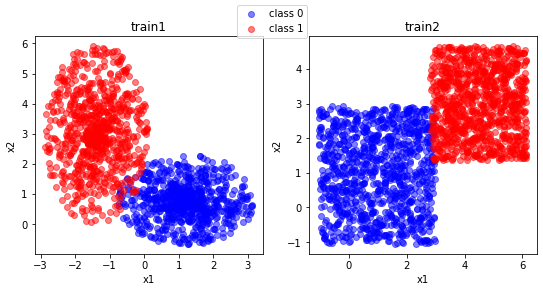

In [10]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(train1_c0.x1, train1_c0.x2, color='blue', alpha=0.5)
ax[0].scatter(train1_c1.x1, train1_c1.x2, color='red', alpha=0.5)
ax[0].set_title('train1')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')

ax[1].scatter(train2_c0.x1, train2_c0.x2, color='blue', alpha=0.5)
ax[1].scatter(train2_c1.x1, train2_c1.x2, color='red', alpha=0.5)
ax[1].set_title('train2')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')

plt.figlegend(['class 0','class 1'], loc = 'upper center')

plt.gcf().set_size_inches(9,4)
plt.show()

##### Means:

In [11]:
train1_mu0_t = train1_c0[['x1','x2']].mean().to_numpy()
train1_mu0 = train1_mu0_t.reshape(-1,1)
train1_mu0

array([[1.18814556],
       [0.74442316]])

Means are different!

In [12]:
train1_mu1_t = train1_c1[['x1','x2']].mean().to_numpy()
train1_mu1 = train1_mu1_t.reshape(-1,1)
train1_mu1

array([[-1.38466842],
       [ 3.07103112]])

Means are different!

In [13]:
train2_mu0_t = train2_c0[['x1','x2']].mean().to_numpy()
train2_mu0 = train2_mu0_t.reshape(-1,1)
train2_mu0

array([[1.],
       [1.]])

Means are the same!

In [14]:
train2_mu1_t = train2_c1[['x1','x2']].mean().to_numpy()
train2_mu1 = train2_mu1_t.reshape(-1,1)
train2_mu1

array([[4.5],
       [3. ]])

Means are different!

#### Covariance Matrices: 

In [15]:
train1_cov0 = cov_matrix(train1_c0)
train1_cov0

array([[ 0.65161 , -0.019441],
       [-0.019441,  0.365065]])

In [16]:
train1_cov1 = cov_matrix(train1_c1)
train1_cov1

array([[0.4132  , 0.013337],
       [0.013337, 1.495048]])

In [17]:
train2_cov0 = cov_matrix(train2_c0)
train2_cov0

array([[ 1.299525e+00, -3.200000e-05],
       [-3.200000e-05,  1.300476e+00]])

In [18]:
train2_cov1 = cov_matrix(train2_c1)
train2_cov1

array([[ 8.99978e-01, -2.00000e-05],
       [-2.00000e-05,  9.00022e-01]])

#### Case1 and 2

In [19]:
def trainBayes(TrainingSamples, TrainingLabel) :

    temp = TrainingSamples[TrainingSamples.y==TrainingLabel][['x1','x2']]
    # calculating the parameters for the given class
    prior = len(temp)/len(TrainingSamples)
    mu_t = np.mean(temp)
    mu = np.transpose(mu_t)
    var = np.var(temp)

    if abs(var[0]-var[1])<10**-3: # different means µi!=µj but constant variance for all data features in each class
        constant_var = True
        print ('Class %s has constant variance for all data features;'%TrainingLabel)
        
        # since the varances are really close, we'll consider the euclidian distance
        W_i = 0
        # Here W_i has is set to zero. This does not affect anything in the calculations later on.
        # This was done in order to have constant number of outputs from this function.
        wi_t = -2*mu_t
        wi_0 = np.dot(mu_t, mu)
        
        # Hereby, I am getting constant_var as a parameter to use later.
        return(W_i, wi_t, wi_0, constant_var)

    else: # Quadradic Function
        constant_var = False
        
        cov = cov_matrix(temp)
        cov_inv = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)
        
        W_i = cov_inv/-2           
        wi_t = np.dot(mu_t, cov_inv)
        wi_0 = ((np.dot(np.dot(mu_t, cov_inv), mu) - np.log(cov_det))/-2) + np.log(prior)
        
        return(W_i, wi_t, wi_0, constant_var)


In [20]:
trained = [] # A list for trained parameters
q = 0
for train in ['train1', 'train2']:
    trained.append([]) # a list within the "trained" list for each dataset 
    
    print ('For %s:\n'%train)
    
    for cls in [0,1]:

        W_i, wi_t, wi_0, constant_var = trainBayes(eval(train), cls)
        parameters = {'W_i':W_i, 'wi_t': wi_t, 'wi_0': wi_0, 'constant_var': constant_var}
        trained[q].append(parameters) # parameters dictionnary is added to the list
        
        # if variances are constant, then use the following formula
        if constant_var:
            print('g%s_X = [%.3f %.3f] X + (%.3f)\n'%(cls, wi_t[0], wi_t[1], wi_0))
            
        # otherwise, general case:
        else:
            print('g%s_X = Xt W%s X + [%.3f %.3f] X + (%.3f)\n'%(cls, cls, wi_t[0], wi_t[1], wi_0))
            
            print ('Where W%s ='%cls)
            for a in range(W_i.shape[0]):
                print ('\t  [%.3f %.3f]'%(W_i[a,0], W_i[a,1]))
            print (' ')
            
    q += 1 

For train1:

g0_X = Xt W0 X + [1.887 2.140] X + (-3.329)

Where W0 =
	  [-0.769 -0.041]
	  [-0.041 -1.372]
 
g1_X = Xt W1 X + [-3.418 2.085] X + (-6.502)

Where W1 =
	  [-1.210 0.011]
	  [0.011 -0.335]
 
For train2:

Class 0 has constant variance for all data features;
g0_X = [-2.000 -2.000] X + (2.000)

Class 1 has constant variance for all data features;
g1_X = [-9.000 -6.000] X + (29.250)



* Parameters for the first dataset (train1) are stored in a list as in the first element of "trained" list:
* In this list "trained[0]" there are two dictionaries for the two classes' parameters.

In [21]:
trained[0]

[{'W_i': array([[-0.76855125, -0.04092807],
         [-0.04092807, -1.37179867]]),
  'wi_t': array([1.88723713, 2.1396544 ]),
  'wi_0': -3.3294970378972,
  'constant_var': False},
 {'W_i': array([[-1.21041629,  0.01079786],
         [ 0.01079786, -0.33453375]]),
  'wi_t': array([-3.41837156,  2.08463002]),
  'wi_0': -6.501761175114304,
  'constant_var': False}]

In [22]:
def predict_class(test, parameters):
    preds = []
    # looping over samples
    for index, sample in test.iterrows():
        
        X_t = sample.values
        X = X_t.reshape(-1,1)
        G_X = []
        
        for cls in [0,1]:
            # unpacking the parameters from the dictionary
            W_i = parameters[cls]['W_i']
            wi_t = parameters[cls]['wi_t']
            wi_0 = parameters[cls]['wi_0']    
            
            # defining the gi_X formula based on constant_var parameter
            if parameters[cls]['constant_var']:
                gi_X = np.dot(wi_t, X) + wi_0
                
            else:
                gi_X = (np.dot(np.dot(X_t, W_i), X) + np.dot(wi_t, X) + wi_0)/-1
                
            G_X.append(gi_X)
        # finding the class    
        min_g = min(G_X)
        if G_X[0] == min_g:
            preds.append(0)
        else:
            preds.append(1)
    return(preds)

In [23]:
# computing error
def compute_error(y, y_hat):
    return np.sum([1 if i!=j else 0 for i, j in zip(y, y_hat)]) / len(y)

In [24]:
t = 0
for test in [test1, test2]:
    X_test = test[['x1','x2']]
    y_hat = predict_class(X_test, trained[t])
    
    error = compute_error(test.y, y_hat)
    print ('The error for test%s is %s\n'%(t+1, error))
    
    t+=1

The error for test1 is 0.015

The error for test2 is 0.0225



### Evaluation of Bayes classifier using 3-fold cross-validation

#### Combining the training set and the test

In [25]:
dataset1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
dataset2 = pd.concat([train2, test2], axis=0).reset_index(drop=True)
dataset2

,x1,x2,y
0,1.941228,1.846020,0.0
1,1.495839,2.698817,0.0
2,4.330579,4.413520,1.0
3,2.737539,2.038206,0.0
4,3.819236,4.541018,1.0
...,...,...,...
2395,-0.478637,1.164457,0.0
2396,5.652354,2.375530,1.0
2397,4.841827,3.260956,1.0
2398,6.149805,3.134701,1.0


#### Performing a 3-fold cross validation

#### Computing gi(x)

In [26]:
# similar to as explained above, hereby the gi_X functions are being printed.
trainedII = []
q = 0
for train in ['dataset1', 'dataset2']:
    trainedII.append([])
    
    print ('For %s:\n'%train)
    
    for cls in [0,1]:

        W_i, wi_t, wi_0, constant_var = trainBayes(eval(train), cls)
        
        if constant_var:
            print('g%s_X = [%.3f %.3f] X + (%.3f)\n'%(cls, wi_t[0], wi_t[1], wi_0))
        else:
            print('g%s_X = Xt W%s X + [%.3f %.3f] X + (%.3f)\n'%(cls, cls, wi_t[0], wi_t[1], wi_0))
            
            print ('Where W%s ='%cls)
            for a in range(W_i.shape[0]):
                print ('\t  [%.3f %.3f]'%(W_i[a,0], W_i[a,1]))
            print (' ')
            
    q += 1 

For dataset1:

g0_X = Xt W0 X + [1.903 2.137] X + (-3.362)

Where W0 =
	  [-0.767 -0.033]
	  [-0.033 -1.374]
 
g1_X = Xt W1 X + [-3.441 2.027] X + (-6.424)

Where W1 =
	  [-1.249 -0.008]
	  [-0.008 -0.339]
 
For dataset2:

g0_X = Xt W0 X + [0.771 0.769] X + (-1.202)

Where W0 =
	  [-0.385 -0.000]
	  [-0.000 -0.385]
 
Class 1 has constant variance for all data features;
g1_X = [-9.000 -6.000] X + (29.250)



#### Finding the classification error rate and computing the average of testing results

In [27]:
kf = KFold(n_splits=3, random_state=314, shuffle=True)

for data in ['dataset1','dataset2']:
    print ('\nFor '+data+':')
    dataset = eval(data)
    
    errors = []
    t = 0
    for train_index, test_index in kf.split(dataset):
        train, test = dataset.loc[train_index], dataset.loc[test_index]

        trainedIII = []
        for cls in [0,1]:
            W_i, wi_t, wi_0, constant_var = trainBayes(train, cls)
            parameters = {'W_i':W_i, 'wi_t': wi_t, 'wi_0': wi_0, 'constant_var': constant_var}
            trainedIII.append(parameters)

        X_test = train[['x1','x2']]
        y_test = train[['y']]
        y_hat = predict_class(X_test, trainedIII)

        error = compute_error(y_test.y, y_hat)
        errors.append(error)
        print ('\tThe error on the test set (fold %s)  is %.3f'%(t+1, error))
        t+=1
    print ('\tThe average error is %.3f'%np.mean(errors))


For dataset1:
	The error on the test set (fold 1)  is 0.011
	The error on the test set (fold 2)  is 0.017
	The error on the test set (fold 3)  is 0.020
	The average error is 0.016

For dataset2:
Class 0 has constant variance for all data features;
	The error on the test set (fold 1)  is 0.499
	The error on the test set (fold 2)  is 0.015
Class 0 has constant variance for all data features;
	The error on the test set (fold 3)  is 0.492
	The average error is 0.336


#### Comparison: 
Considering the results of K-Fold cross-validation, we can see that the average error is lower for dataset2, and it is almost the same for dataset1. Thus, it is recommended to do cross-validation to lower the error on unseen test set, and prevent overfitting. 

### Semi-Supervised Learning on Dataset 3 using Bayes Classifier

#### Ploting the training Dataset 3

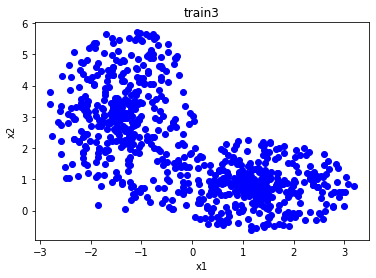

In [28]:
plt.scatter(train3.x1, train3.x2, color='blue')
plt.title('train3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

* As a conclusion, this datasets is similar to dataset 1. 

#### Training a Bayes classifier using the training Dataset 1

I have already trained my classifier on training Dataset 1, and I have stored its parameters. So hereby I will use it to assign pseudo-label for training Dataset 3.

In [29]:
# The parameters are stored in trained[0]
trained[0]

[{'W_i': array([[-0.76855125, -0.04092807],
         [-0.04092807, -1.37179867]]),
  'wi_t': array([1.88723713, 2.1396544 ]),
  'wi_0': -3.3294970378972,
  'constant_var': False},
 {'W_i': array([[-1.21041629,  0.01079786],
         [ 0.01079786, -0.33453375]]),
  'wi_t': array([-3.41837156,  2.08463002]),
  'wi_0': -6.501761175114304,
  'constant_var': False}]

In [30]:
X_train3 = train3[['x1','x2']]
train3['y_hat'] = predict_class(X_train3, trained[0])
train3

,x1,x2,y,y_hat
0,2.328009,-0.054717,0.0,0
1,-0.826687,4.044049,1.0,1
2,-1.367783,2.711673,1.0,1
3,1.181950,0.929444,0.0,0
4,-1.632349,3.952147,1.0,1
...,...,...,...,...
795,-1.182370,2.306965,1.0,1
796,-1.356024,2.949347,1.0,1
797,1.178004,0.776796,0.0,0
798,-1.261943,2.137456,1.0,1


In [31]:
train3_new = train3.drop('y', axis=1)
train3_new = train3_new.rename(columns={'y_hat':'y'})
train13 = pd.concat([train1,train3_new]).reset_index(drop=True)
train13

,x1,x2,y
0,1.143987,0.339646,0.0
1,2.284493,1.129224,0.0
2,1.053601,0.573296,0.0
3,-0.652288,3.116746,1.0
4,-0.223255,3.463650,1.0
...,...,...,...
2395,-1.182370,2.306965,1.0
2396,-1.356024,2.949347,1.0
2397,1.178004,0.776796,0.0
2398,-1.261943,2.137456,1.0


In [32]:
trainedIIII = []
for cls in [0,1]:
    W_i, wi_t, wi_0, constant_var = trainBayes(train13, cls)
    parameters = {'W_i':W_i, 'wi_t': wi_t, 'wi_0': wi_0, 'constant_var': constant_var}
    trainedIIII.append(parameters)

print ('A new Bayes classifier on both training Dataset 1 + pseudo-labeled Dataset 3 were performed\nParameters: \n')
print(trainedIIII)

A new Bayes classifier on both training Dataset 1 + pseudo-labeled Dataset 3 were performed
Parameters: 

[{'W_i': array([[-0.78998069, -0.01622076],
       [-0.01622076, -1.34184065]]), 'wi_t': array([1.93919546, 2.06496753]), 'wi_0': -3.3771956583916882, 'constant_var': False}, {'W_i': array([[-1.27478431,  0.00966216],
       [ 0.00966216, -0.3310533 ]]), 'wi_t': array([-3.57270972,  2.06008506]), 'wi_0': -6.57245540811025, 'constant_var': False}]


In [33]:
X_test = test1[['x1','x2']]
y_hat = predict_class(X_test, trainedIIII)

error = compute_error(test.y, y_hat)
print ('Based on Bayes classifier on both training Dataset 1 + pseudo-labeled Dataset 3;')
print ('The error for test1 is %s\n'%(error))
    

Based on Bayes classifier on both training Dataset 1 + pseudo-labeled Dataset 3;
The error for test1 is 0.24



#### As a conclusion, adding  pseudo-labeled data did not help!